In [80]:
# Some parts of this code are taken from
# https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(22) # that's my lucky number

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# a helper class to encode and decode sequences from one-hot encoding
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)
    
# Parameters for the model and dataset.
TRAINING_SIZE = 1000
DIGITS = 20 # max input size that the model can accept
MAXLEN = DIGITS + 2 # s(start symbol) + number + e(end symbol)

# All the numbers, plus sign and space for padding.
chars = '0123456789se '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
# This is the primary dataset
# we will use numbers upto 10 digits only
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, 10))))
    a = f()
    b = a + 1
    key = (a, b)
    if key in seen:
        continue
    seen.add(key)
    
    q = 'e{}s'.format(a)
    query = ' ' * (MAXLEN - len(q)) + q
    ans = 'e{}s'.format(b)
    ans = ' ' * (MAXLEN - len(ans)) + ans
    
    ans= ans[::-1]
    query = query[::-1]
    questions.append(query)
    expected.append(ans)

# There will be very few examples in the primary dataset which looks like 1239999999999999. If we use only primary
# dataset then the rnn will fail on these type of examples. Because it fails to remember carry for this longer.
# so here is a small dataset of 100 examples which contains numbers of the form ...99999999999.
# If we also train on this one then the model works for all type of input
# This is just a hack but it works!
'''
while len(questions) < TRAINING_SIZE + 10:
    f = lambda: int(''.join(np.random.choice(list('123456789'))
                    for i in range(np.random.randint(0,3))) + '9'*np.random.randint(1, 7))
    a = f()
    b = a + 1

    key = (a, b)
    if key in seen:
        continue
    seen.add(key)
    
    q = 'e{}s'.format(a)
    query = ' ' * (MAXLEN - len(q)) + q
    ans = 'e{}s'.format(b)
    ans = ' ' * (MAXLEN - len(ans)) + ans
    
    ans= ans[::-1]
    query = query[::-1]
    
    questions.append(query)
    expected.append(ans)
'''
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.int32)
y = np.zeros((len(questions), MAXLEN), dtype=np.int32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = np.array([ctable.char_indices[z] for z in sentence])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Generating data...
('Total addition questions:', 1000)
Vectorization...
Training Data:
(900, 22, 13)
(900, 22)
Validation Data:
(100, 22, 13)
(100, 22)


In [103]:
D = len(chars) #input dimension
C = len(chars) #output dimension
T = MAXLEN # truncated backprop length
N = 5 #batch_size
H = 50 #hidden dimension
num_epochs = 50
num_batches = x_train.shape[0]//N
batch_size = N

# build tensorflow model
tf.reset_default_graph()

x_batch = tf.placeholder(tf.float32, [None,T,D], name='x_batch')
y_batch = tf.placeholder(tf.int64, [None,T], name='y_batch')

N = tf.shape(x_batch)[0]
cell_state = tf.zeros([N,H], dtype=tf.float32)
hidden_state = tf.zeros([N,H], dtype=tf.float32)
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)

#w_init = tf.zeros([H, C], name='wc_init') amazing results!!
w_init = tf.random_normal([H, C], name='wc_init')
b_init = tf.zeros([1, C], name='bc_init')
W = tf.Variable(w_init, dtype=tf.float32, name='wc')
b = tf.Variable(b_init, dtype=tf.float32, name='bc')

cell = tf.contrib.rnn.BasicLSTMCell(H, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, x_batch, initial_state=init_state)
#print (states_series) to get name!!
#tf.summary.histogram('activation', states_series)
states_series = tf.reshape(states_series, [-1, H])
logits = tf.matmul(states_series, W) + b
logits = tf.reshape(logits, [-1,T,C])
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_batch)
prob = tf.nn.softmax(logits)
pred = tf.argmax(prob, axis=-1, name='pred')
acc = tf.contrib.metrics.accuracy(pred, y_batch)

total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(1).minimize(total_loss)

#writer = tf.summary.FileWriter('digit_rnn_summary')

In [104]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.set_random_seed(22)
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    loss_list = []

    # train our model
    for epoch_idx in range(num_epochs):
        print("Epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            x_data = x_train[start_idx:end_idx]
            y_data = y_train[start_idx:end_idx]

            _total_loss, _train_step, batchP = sess.run(
                [total_loss, train_step, pred],
                feed_dict={
                    x_batch: x_data,
                    y_batch: y_data
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)

        train_acc = sess.run(acc, { x_batch: x_train, y_batch: y_train })
        validation_acc = sess.run(acc, { x_batch: x_val, y_batch: y_val })
        print ('Training accuracy: ', train_acc)
        print ('Validation accuracy: ', validation_acc)
    
    saver.save(sess, 'my-model')

('Epoch', 0)
('Step', 0, 'Batch loss', 3.1184201)
('Step', 100, 'Batch loss', 0.19927643)
('Training accuracy: ', 0.99469697)
('Validation accuracy: ', 0.99636364)
('Epoch', 1)
('Step', 0, 'Batch loss', 0.056793541)
('Step', 100, 'Batch loss', 0.064984865)
('Training accuracy: ', 0.99929291)
('Validation accuracy: ', 0.99863636)
('Epoch', 2)
('Step', 0, 'Batch loss', 0.015961962)
('Step', 100, 'Batch loss', 0.015646083)
('Training accuracy: ', 0.99989897)
('Validation accuracy: ', 0.99909091)
('Epoch', 3)
('Step', 0, 'Batch loss', 0.0049323961)
('Step', 100, 'Batch loss', 0.0070598843)
('Training accuracy: ', 0.99989897)
('Validation accuracy: ', 0.99909091)
('Epoch', 4)
('Step', 0, 'Batch loss', 0.0026169368)
('Step', 100, 'Batch loss', 0.0044403938)
('Training accuracy: ', 0.99989897)
('Validation accuracy: ', 0.99909091)
('Epoch', 5)
('Step', 0, 'Batch loss', 0.0017282484)
('Step', 100, 'Batch loss', 0.0031982216)
('Training accuracy: ', 0.99989897)
('Validation accuracy: ', 0.99909

INFO:tensorflow:Restoring parameters from ./my-model


INFO:tensorflow:Restoring parameters from ./my-model


<tf.Variable 'wc:0' shape=(50, 13) dtype=float32_ref>
<tf.Variable 'bc:0' shape=(1, 13) dtype=float32_ref>
<tf.Variable 'rnn/basic_lstm_cell/weights:0' shape=(63, 200) dtype=float32_ref>
<tf.Variable 'rnn/basic_lstm_cell/biases:0' shape=(200,) dtype=float32_ref>
('Wc', -0.020422399, 1.1570398)
('Wc_init', -0.065428562, 1.0005232)
('diff', 0.045006175, 1.5459723)


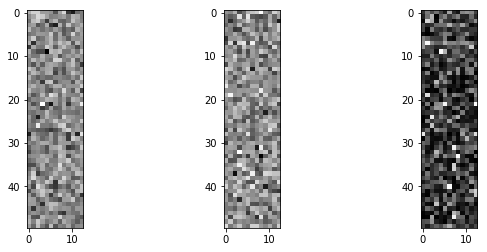

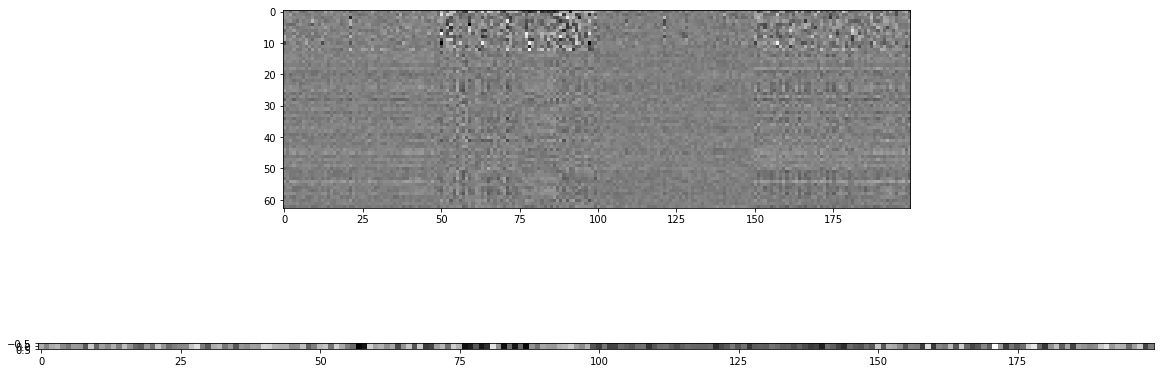

(1, 22, 50)
('s000000000000000001e  ', 's00000999999999999e   ')
Wrong!


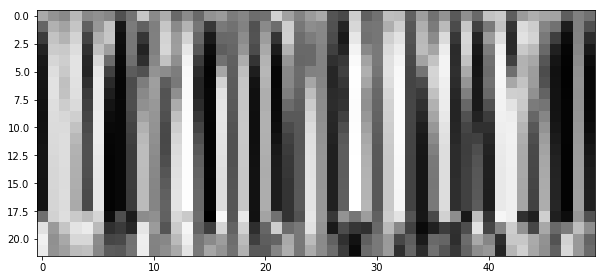

In [102]:
tf.reset_default_graph()
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my-model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    graph = tf.get_default_graph()
    x_batch = graph.get_tensor_by_name("x_batch:0")
    pred = graph.get_tensor_by_name("pred:0")
    
    for v in graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v)
        
    w_lstm = graph.get_tensor_by_name('rnn/basic_lstm_cell/weights:0')
    b_lstm = graph.get_tensor_by_name('rnn/basic_lstm_cell/biases:0')
    wc = graph.get_tensor_by_name('wc:0')
    bc = graph.get_tensor_by_name('bc:0')
    wc_init = graph.get_tensor_by_name('wc_init:0')
    bc_init = graph.get_tensor_by_name('bc_init:0')
    act = graph.get_tensor_by_name('rnn/transpose:0')
    
    Wc, Bc, Wc_init, Bc_init, W_lstm, B_lstm = sess.run(
                [wc, bc, wc_init, bc_init, w_lstm, b_lstm]
            )
    
    print ("Wc", np.mean(Wc), np.std(Wc))
    print ("Wc_init", np.mean(Wc_init), np.std(Wc_init))
    print ("diff", np.mean(Wc-Wc_init), np.std(Wc-Wc_init))
    plt.subplot(1, 3, 1)
    plt.imshow(Wc)
    plt.subplot(1, 3, 2)
    plt.imshow(Wc_init)
    plt.subplot(1, 3, 3)
    plt.imshow(np.absolute(Wc_init-Wc))
    plt.gcf().set_size_inches(10, 4)
    plt.show()
    
    plt.subplot(2, 1, 1)
    plt.imshow(W_lstm)
    plt.subplot(2, 1, 2)
    plt.imshow(B_lstm.reshape((1,-1)))
    plt.gcf().set_size_inches(20, 8)
    plt.show()
    
    # play with the model
    # input any number (up to 20 digits!) and get the predicted output
    
    
    
    q = 99999999999999999
    query = 's'+ str(q)[::-1] + 'e' + ' '*(MAXLEN-len(str(q))-2)
    x = np.reshape(ctable.encode(query, MAXLEN),(1,MAXLEN,C))
    p, act = sess.run([pred, act], { x_batch: x })
    print (act.shape)
    plt.subplot(1, 1, 1)
    plt.imshow(act[0])
    
    q += 1
    gtruth = 's'+str(q)[::-1]+'e'+(' ')*(MAXLEN-len(str(q))-2)
    pred = ''.join([ctable.indices_char[c] for c in p[0]])
    print (gtruth, pred)
    if gtruth!=pred:
        print ('Wrong!')
    else:
        print ('Correct!')